# Part 1 - Common Analysis | Model Predictions

Common Analysis is the first step of our borader project that focuses on the impact of the wildfires in US. In this common analysis, we are going into the first analyze in detail the fires of our alloted city and come up with an estimate. This is a rough estimate the wildfire impacts on the city which might have a more profound negative effect on health, tourism, property, and other aspects of society.

In this notebook we will develop a predictive model based on the fire data and smoke estimate for your assigned city. The model should predict smoke estimates for every year for the next 25 years (i.e., 2024-2049). You should be careful to make sure your predictions convey appropriate levels of uncertainty in the prediction.


# Setup

We first set the working dependencies and constants that are required to build the predictive network.

The setup contains the following steps

1. Import all relevant packages
2. Define all the relevant constants that will be used throughout the script.

In [1]:
# import packages
import re
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# define all the file name to access throughout the scripts

smoke_est_df = pd.read_csv(r"C:\Users\shwet\Downloads\Data512 - ProjectPart1_CommonAnalysis_ShwetaManjunath\Data\processed_data\yearly_smoke_estimates.csv", index_col = 0)
# sample
smoke_est_df

,year,GIS_Acres,Shape_Area,shortest_dist,fire_intensity,scaled_overlap_component,smoke_estimate,aqi
0,1963.0,691.834084,2.799753e+06,886.566366,3.348336e+06,0.000017,7.409755,0.000000
1,1964.0,943.032726,3.816318e+06,942.635637,3.880452e+06,0.000023,9.473445,0.000000
2,1965.0,686.502917,2.778179e+06,983.856358,2.800565e+06,0.000708,6.415212,0.000000
3,1966.0,1470.830214,5.952239e+06,916.784617,6.370382e+06,0.000026,8.631456,0.000000
4,1967.0,779.612520,3.154980e+06,978.286460,3.161821e+06,0.001162,6.593157,0.000000
...,...,...,...,...,...,...,...,...
56,2019.0,793.084805,3.209500e+06,865.479474,3.297554e+06,0.000344,11.554043,8.030042
57,2020.0,2083.377696,8.431130e+06,817.544346,9.693808e+06,0.000178,8.339470,14.099363
58,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,18.852270
59,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,17.592467


# Step 1 - Build the predictive model 

We are going to be building a time series model as we have to predict the smoke estimate for the next 25 years. Since we don't have the ground truth for the predictors, we have to use the features as regressors. The model chosen is a SARIMA model since there is a seasonality component for the wild fires (The wildfire season).

In [3]:
# converting the year column into a timestamp
smoke_est_df['year'] = pd.to_datetime(smoke_est_df['year'], format='%Y')  
# Rename your timestamp and target columns as required by SARIMAX
df_sarimax = smoke_est_df.rename(columns={'year': 'ds', 'smoke_estimate': 'y'})
# Sample
df_sarimax = df_sarimax[~df_sarimax['y'].isnull()]
df_sarimax

,ds,GIS_Acres,Shape_Area,shortest_dist,fire_intensity,scaled_overlap_component,y,aqi
0,1963-01-01,691.834084,2.799753e+06,886.566366,3.348336e+06,0.000017,7.409755,0.000000
1,1964-01-01,943.032726,3.816318e+06,942.635637,3.880452e+06,0.000023,9.473445,0.000000
2,1965-01-01,686.502917,2.778179e+06,983.856358,2.800565e+06,0.000708,6.415212,0.000000
3,1966-01-01,1470.830214,5.952239e+06,916.784617,6.370382e+06,0.000026,8.631456,0.000000
4,1967-01-01,779.612520,3.154980e+06,978.286460,3.161821e+06,0.001162,6.593157,0.000000
5,1968-01-01,676.723133,2.738601e+06,996.562790,2.764659e+06,0.000158,8.650442,0.000000
6,1969-01-01,510.362125,2.065362e+06,980.113564,2.104951e+06,0.000135,7.775776,0.000000
7,1970-01-01,1015.245169,4.108551e+06,941.389885,4.201760e+06,0.000068,9.188843,0.000000
8,1971-01-01,1392.319890,5.634519e+06,879.754963,6.630058e+06,0.000085,10.242204,0.000000
9,1972-01-01,747.814787,3.026299e+06,957.926527,3.313837e+06,0.000025,9.040093,0.000000


In [4]:
# Set the timestamp column as the index
df_sarimax.set_index('ds', inplace=True)

In [5]:
# Fit SARIMA model
order = (1, 1, 1)  # Order parameters (p, d, q)

# the seasonal perod is assumed to be 6 months for the wildfire period
seasonal_order = (1, 1, 1, 6)  # Seasonal order parameters (P, D, Q, S)

Here, we are not using exogenous variables as we don't have the data for the future years

In [6]:
# Frain the model
exog_variables = df_sarimax[['GIS_Acres','Shape_Area','shortest_dist','fire_intensity','scaled_overlap_component']]
model = SARIMAX(df_sarimax['y'], order=order, seasonal_order=seasonal_order)
results = model.fit()

In [7]:
# Forecast future values
forecast_steps = 25  # Adjust the number of steps as needed
forecast = results.get_forecast(steps=forecast_steps)

# Extracting forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
print("The Forecasted value for the next 25 years")
print(forecasted_values)

The Forecasted value for the next 25 years
2021-01-01    9.925103
2022-01-01    8.519219
2023-01-01    9.701722
2024-01-01    9.217005
2025-01-01    9.515492
2026-01-01    8.911450
2027-01-01    9.649590
2028-01-01    8.975853
2029-01-01    9.524305
2030-01-01    9.584105
2031-01-01    9.407868
2032-01-01    9.198266
2033-01-01    9.590290
2034-01-01    9.215479
2035-01-01    9.505767
2036-01-01    9.788545
2037-01-01    9.419748
2038-01-01    9.376513
2039-01-01    9.624873
2040-01-01    9.374139
2041-01-01    9.557267
2042-01-01    9.932595
2043-01-01    9.483866
2044-01-01    9.509664
2045-01-01    9.698403
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [8]:
confidence_intervals = forecast.conf_int()
confidence_intervals

,lower y,upper y
2021-01-01,7.840488,12.009717
2022-01-01,6.168157,10.870282
2023-01-01,6.650660,12.752784
2024-01-01,5.939236,12.494773
2025-01-01,5.758312,13.272672
2026-01-01,4.940882,12.882017
2027-01-01,5.220576,14.078604
2028-01-01,4.314491,13.637215
2029-01-01,4.493444,14.555167
2030-01-01,4.336040,14.832170


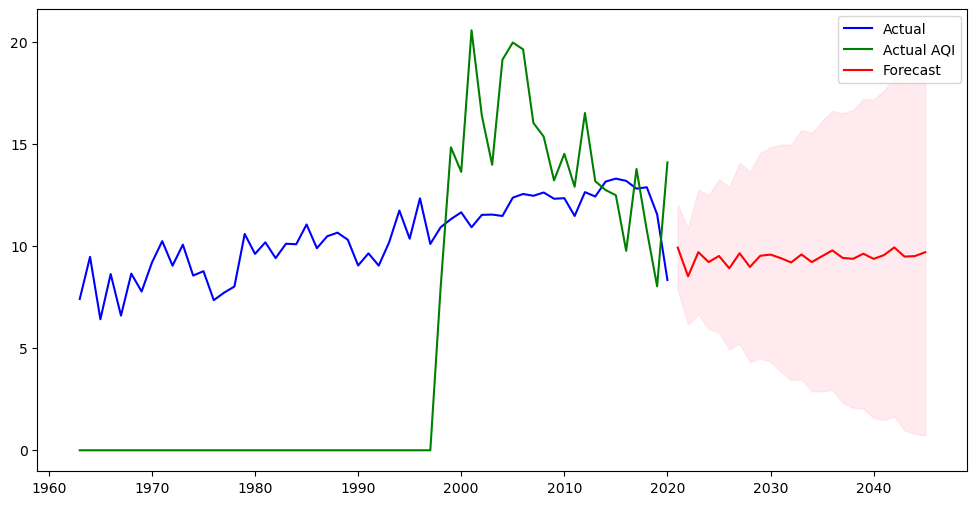

In [9]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_sarimax['y'], label='Actual', color='blue')
plt.plot(df_sarimax['aqi'], label='Actual AQI', color='green')
plt.plot(forecasted_values.index, forecasted_values.values, label='Forecast', color='red')

plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# Analysis Visualization

## Historgram

Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

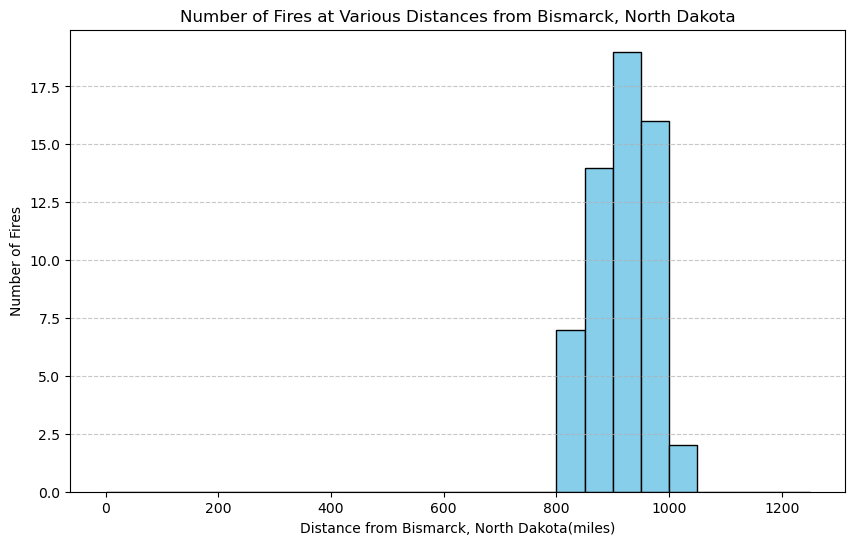

In [10]:
# Define the maximum specified distance
max_distance = 1250  

# Create a histogram with bins every 50 miles up to the max specified distance
plt.figure(figsize=(10, 6))
plt.hist(smoke_est_df['shortest_dist'], bins=range(0, max_distance + 50, 50), color='skyblue', edgecolor='black')
plt.xlabel('Distance from Bismarck, North Dakota(miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires at Various Distances from Bismarck, North Dakota')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##  Time series Graph

Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

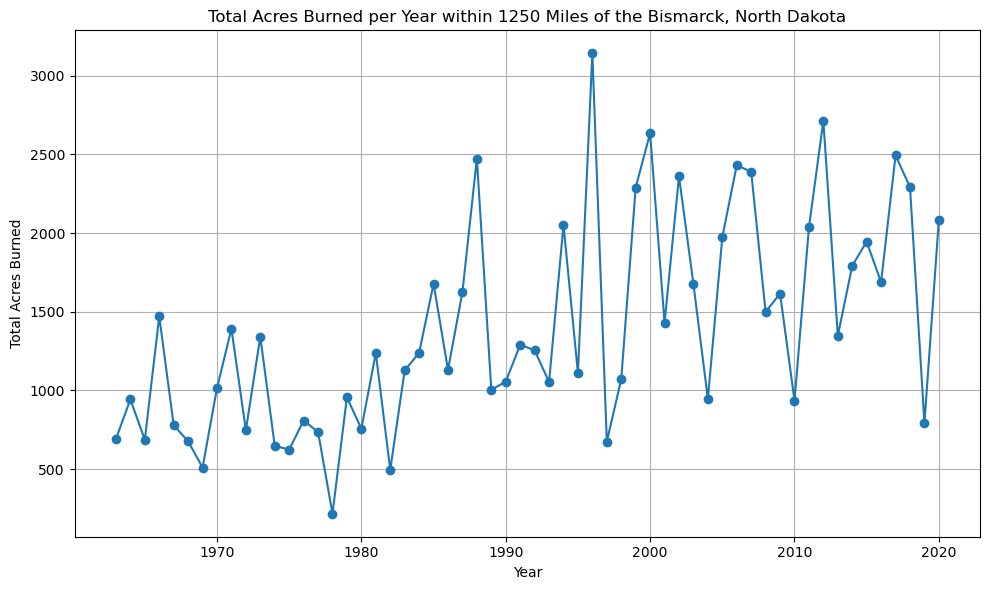

In [11]:
# Filter fires within the specified distance
specified_distance = 1250 
fires_within_distance = smoke_est_df[smoke_est_df['shortest_dist'] <= specified_distance]

# Group by year and calculate total acres burned per year
acres_burned_per_year = fires_within_distance.groupby(fires_within_distance['year']).agg({'GIS_Acres': 'sum'})

# Plotting the time series graph
plt.figure(figsize=(10, 6))
plt.plot(acres_burned_per_year.index, acres_burned_per_year['GIS_Acres'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Total Acres Burned per Year within {specified_distance} Miles of the Bismarck, North Dakota')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Time series Graph

Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

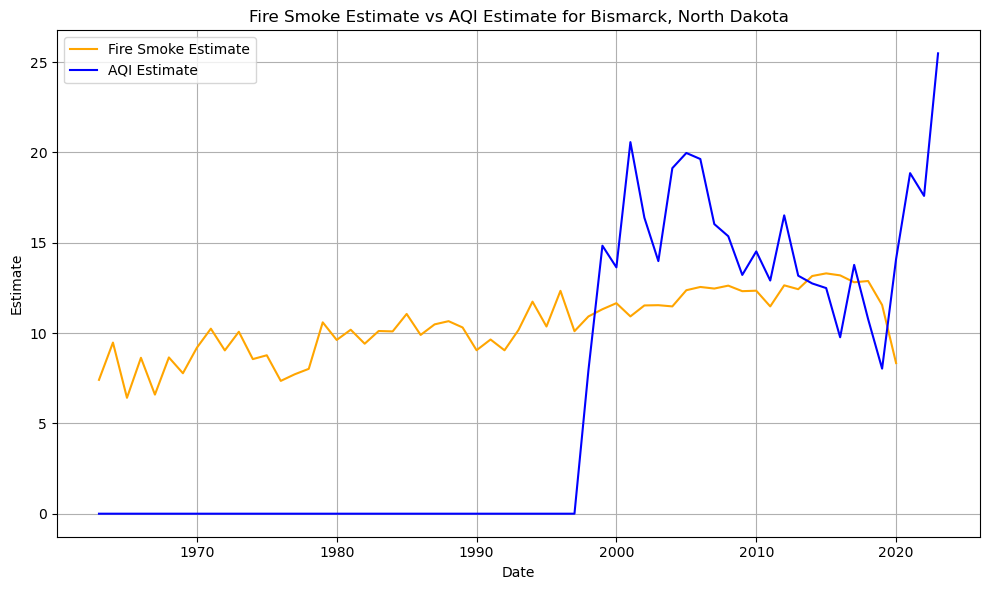

In [12]:
# Plotting the time series graph
plt.figure(figsize=(10, 6))

# Plot fire smoke estimate
plt.plot(smoke_est_df['year'], smoke_est_df['smoke_estimate'], label='Fire Smoke Estimate', color='orange')

# Plot AQI estimate
plt.plot(smoke_est_df['year'], smoke_est_df['aqi'], label='AQI Estimate', color='blue')

plt.xlabel('Date')
plt.ylabel('Estimate')
plt.title('Fire Smoke Estimate vs AQI Estimate for Bismarck, North Dakota')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
